In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.decomposition import TruncatedSVD
import re

In [75]:
pd.set_option('display.max_rows', 15)

In [76]:
data = pd.read_csv('../data/news_articles.csv')

In [77]:
data.columns

Index(['author', 'published', 'title', 'text', 'language', 'site_url',
       'main_img_url', 'type', 'label', 'title_without_stopwords',
       'text_without_stopwords', 'hasImage'],
      dtype='object')

In [78]:
data.head(5)

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   2096 non-null   object 
 1   published                2096 non-null   object 
 2   title                    2096 non-null   object 
 3   text                     2050 non-null   object 
 4   language                 2095 non-null   object 
 5   site_url                 2095 non-null   object 
 6   main_img_url             2095 non-null   object 
 7   type                     2095 non-null   object 
 8   label                    2095 non-null   object 
 9   title_without_stopwords  2094 non-null   object 
 10  text_without_stopwords   2046 non-null   object 
 11  hasImage                 2095 non-null   float64
dtypes: float64(1), object(11)
memory usage: 196.6+ KB


In [80]:
data.describe(include='object').T

,count,unique,top,freq
author,2096,491,No Author,505
published,2096,2006,2016-10-30T13:00:00.000+02:00,8
title,2096,1784,no title,186
text,2050,1941,notify me of followup comments by email notify...,6
language,2095,5,english,2017
site_url,2095,68,wnd.com,100
main_img_url,2095,1229,No Image URL,466
type,2095,8,bs,601
label,2095,2,Fake,1294
title_without_stopwords,2094,1780,title,187


In [81]:
data.isnull().sum()

author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
label                       1
title_without_stopwords     2
text_without_stopwords     50
hasImage                    1
dtype: int64

In [82]:
#Handle missing data

# Drop a row with missing values on most of the columns
# data[data['language'].isnull()]
data = data[data['language'].notnull()]

# Can retain a few rows if just dropping null in text
# and create the text_without_stopwords from the text ourselves
data = data[data['text_without_stopwords'].notnull()]

# impute the missing title_without_stopwords with title for a row
data[data['title_without_stopwords'].isnull()]
data.loc[data['title_without_stopwords'].isnull(), 'title_without_stopwords'] = data.loc[data['title_without_stopwords'].isnull(), 'title']

# inspect the imputed title_without_stopwords row
print(data.iloc[374])

data.isnull().sum()

author                                                       Daniel Haiphong
published                                      2016-11-17T02:00:00.000+02:00
title                                                           won now what
text                       the syrian army and hezbollah resistance force...
language                                                             english
site_url                                                       ahtribune.com
main_img_url               http://ahtribune.com/images/media/Donald_Trump...
type                                                                      bs
label                                                                   Fake
title_without_stopwords                                         won now what
text_without_stopwords     syrian army hezbollah resistance forces contin...
hasImage                                                                 1.0
Name: 374, dtype: object


author                     0
published                  0
title                      0
text                       0
language                   0
site_url                   0
main_img_url               0
type                       0
label                      0
title_without_stopwords    0
text_without_stopwords     0
hasImage                   0
dtype: int64

In [83]:
# Inspect other languages
print(data['language'].value_counts())
data_other_language = data[data['language'] != 'english']
data_other_language

language
english    1968
german       72
ignore        3
french        2
spanish       1
Name: count, dtype: int64


,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
848,davidduke.com,http://davidduke.com/wp-content/uploads/2014/0...,hate,httpmediaarchivesgsradionetddukemp dr duke fa...,ignore,davidduke.com,http://davidduke.com/wp-content/uploads/2016/1...,hate,Real,billion dollars jewish lobby tip iceberg,views share remarkable articleand admissionapp...,1.0
850,Staff,2016-11-20T14:58:00.000+02:00,billion dollars for the jewish lobby just the ...,views share in a remarkable articleand admiss...,ignore,davidduke.com,http://davidduke.com/wp-content/uploads/2016/1...,hate,Real,dont want break families encourage unaccompani...,share national bugle radio first step towards ...,1.0
855,Dr. Patrick Slattery,2016-11-22T10:47:49.603+02:00,national bugle radio the first step towards ov...,share \ntulsi gabbard for secretary of state a...,ignore,davidduke.com,http://davidduke.com/wp-content/uploads/2016/1...,hate,Real,dr duke pastor dankof trumps america first for...,september new homes sales rise back level davi...,1.0
936,No Author,2016-11-23T12:44:09.173+02:00,sparks fly as bikers for trump meet protesters,umfrage ceta würde enorm an zustimmung gewinne...,german,der-postillon.com,https://1.bp.blogspot.com/-fX3NNr8NmaE/Uci9s8r...,bs,Fake,weil sie sich prügelten gefängnisdirektor erte...,morgen neu kiosk postillon sonntag außerdem di...,1.0
937,noreply@blogger.com (Der Postillon),2016-10-27T10:54:56.270+03:00,studie beweist indianer kennen doch schmerz,steht ganz neben sich klonforscher nach erfolg...,german,der-postillon.com,https://3.bp.blogspot.com/-AgNqsD25l6M/WBHXDg6...,bs,Fake,umfrage ceta würde enorm zustimmung gewinnen w...,samstag oktober autofahrer entlarvt geheimen z...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1006,noreply@blogger.com (Der Postillon),2016-11-21T18:16:38.932+02:00,sicher trainieren beim spinning gilt ab sofort...,posted on october by admin \nby vekar \none ...,german,der-postillon.com,https://4.bp.blogspot.com/-KPp1fzVKeEc/U_XOjN6...,bs,Fake,facebook geht gegen fakenews vor alle meldunge...,notify followup comments email notify new post...,1.0
1007,noreply@blogger.com (Der Postillon),2016-11-22T11:15:13.537+02:00,studie lohnzahlungen verursachen milliardensch...,published on may by cbs sunday morning there...,german,der-postillon.com,https://3.bp.blogspot.com/-lwOiXNE4v5g/WDQ0IQ_...,bs,Fake,bait switch elections,notify followup comments email notify new post...,1.0
1499,No Author,2016-11-01T09:31:48.155+02:00,presstvhezbollah shares aouns victory lebanon fm,the energy minister of iran hamid chitchian \n...,french,presstv.com,http://media.presstv.com/photo/20161026/956c0e...,state,Real,presstvus troops could prosecuted war crimes,news bulletin rita jeptoo celebrates trophy wi...,1.0
1878,"Gordon Duff, Senior Editor",2016-10-28T21:41:33.777+03:00,is alex jones covering for trumps jewish mob t...,lying arrogant muslim marxist piece of dogsht,french,voltairenet.org,http://www.voltairenet.org/local/cache-vignett...,bs,Fake,social media censoring fbis reopened clinton e...,lies esteemed scandalous liberal muslim leader...,0.0


In [84]:
# clean data
data['language'] = data['language'].replace('spanish', 'english')
data['language'] = data['language'].replace('french', 'english')
data['language'] = data['language'].replace('ignore', 'english')
data = data[data['language'] != 'german']

data['language'].value_counts()

language
english    1974
Name: count, dtype: int64

In [85]:
data['label'].value_counts()

label
Fake    1220
Real     754
Name: count, dtype: int64

In [86]:
# def clean_text(text):
#     if isinstance(text, str):
#         # remove URLs
#         text = re.sub(r'http\S+|www\S+', '', text)
#     return text

# data['title_without_stopwords'] = data['title_without_stopwords'].apply(clean_text)
# data['text_without_stopwords'] = daat['text_without_stopwords'].apply(clean_text)

In [87]:
print(data['label'].value_counts())
data['label'] = data['label'].replace({'Fake': 1, 'Real': 0})
data['label'].astype(int)

label
Fake    1220
Real     754
Name: count, dtype: int64


/var/folders/cv/swyglqyx1tlc_6vc0p615fhr0000gn/T/ipykernel_69408/2819706040.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['label'] = data['label'].replace({'Fake': 1, 'Real': 0})


0       0
1       0
2       0
3       0
4       0
       ..
2041    0
2042    0
2043    0
2044    0
2045    0
Name: label, Length: 1974, dtype: int64

In [88]:
# preprocess author column
author_count = data['author'].value_counts()
# print(author_count)

author_threshold = author_count.quantile(0.9)
print(author_threshold)

top_authors = author_count[author_count >= author_threshold].index

data['author'] = data['author'].apply(lambda x: x if x in top_authors else 'Others')

print(data['author'].value_counts())

5.0
author
Others                   572
No Author                504
Activist Post             82
EdJenner                  73
Anonymous                 58
                        ... 
Twain Yobra                5
Infowars Nightly News      5
Kit Daniels                5
Michael Sebastian          5
Barracuda Brigade          5
Name: count, Length: 57, dtype: int64


In [89]:
# preprocess author column
url_count = data['site_url'].value_counts()
# print(url_count)

url_threshold = 5
top_urls = url_count[url_count >= url_threshold].index

data['site_url'] = data['site_url'].apply(lambda x: x if x in top_urls else 'Others')

print(data['site_url'].value_counts())

site_url
awdnews.com                       100
frontpagemag.com                  100
naturalnews.com                   100
politicususa.com                  100
presstv.ir                        100
                                 ... 
theeconomiccollapseblog.com         8
thedailysheeple.com                 7
davidstockmanscontracorner.com      7
newstarget.com                      5
galacticconnection.com              5
Name: count, Length: 40, dtype: int64


site_url
awdnews.com              100
frontpagemag.com         100
naturalnews.com          100
politicususa.com         100
presstv.ir               100
prisonplanet.com         100
clickhole.com            100
infowars.com             100
returnofkings.com        100
westernjournalism.com    100
activistpost.com         100
abeldanger.net            82
dailywire.com             81
ahtribune.com             68
abovetopsecret.com        53
Name: count, dtype: int64


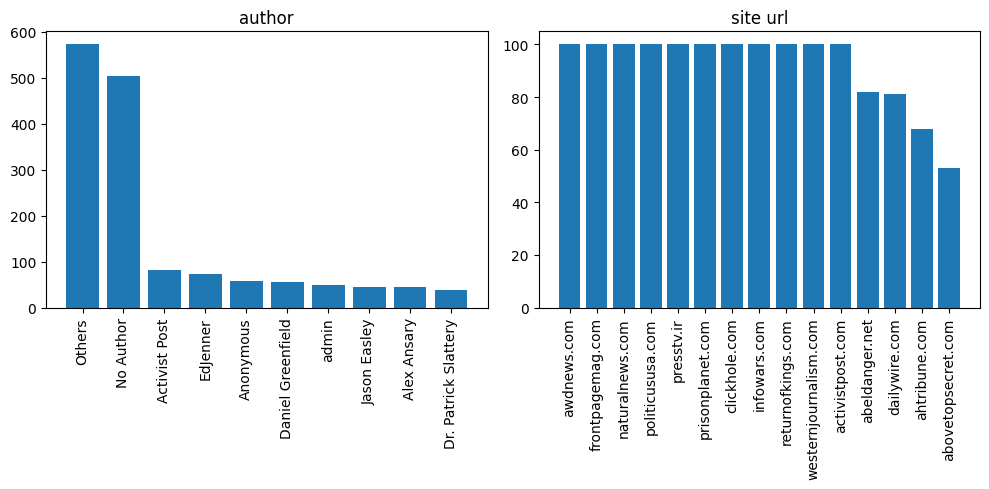

In [90]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

author_count_plot = data['author'].value_counts()[:10]
ax[0].bar(author_count_plot.index, author_count_plot.values)
ax[0].set_xticks(range(len(author_count_plot)))
ax[0].set_xticklabels(author_count_plot.index, rotation=90)
ax[0].set_title('author')

url_count = data['site_url'].value_counts()[:15]
print(url_count)
ax[1].bar(url_count.index, url_count.values)
ax[1].set_xticks(range(len(url_count)))
ax[1].set_xticklabels(url_count.index, rotation=90)
ax[1].set_title('site url')

plt.tight_layout()

plt.savefig('../figures/author_and_url.jpeg')

type
bs            527
conspiracy    430
bias          389
hate          244
satire        146
state         121
junksci       102
fake           15
Name: count, dtype: int64
label
1    1220
0     754
Name: count, dtype: int64


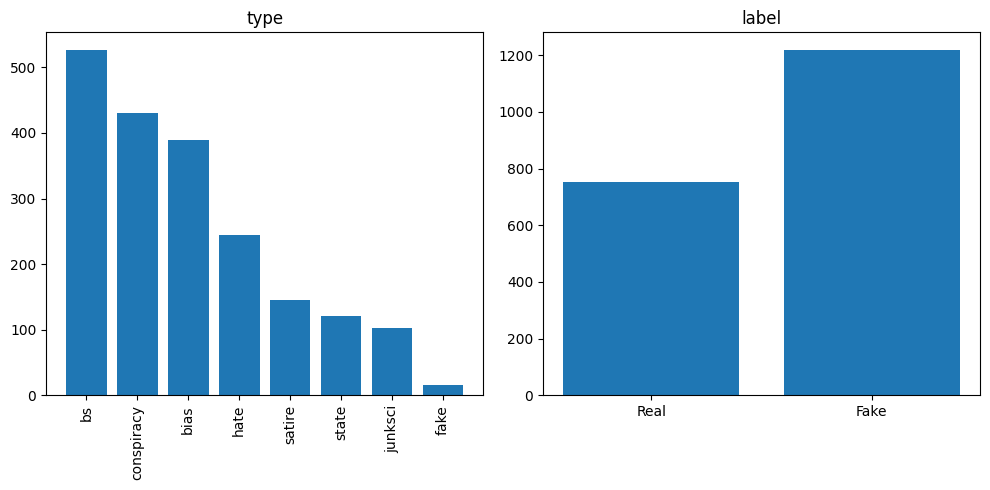

In [91]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

type_count = data['type'].value_counts()
print(type_count)
ax[0].bar(type_count.index, type_count.values)
ax[0].set_xticks(range(len(type_count)))
ax[0].set_xticklabels(type_count.index, rotation=90)
ax[0].set_title('type')

label_count = data['label'].value_counts()[:20]
print(label_count)
ax[1].bar(label_count.index, label_count.values)
ax[1].set_xticks(range(len(label_count)))
ax[1].set_xticklabels(['Real', 'Fake'])
ax[1].set_title('label')

plt.tight_layout()

plt.savefig('../figures/type_and_label.jpeg')

In [92]:
# combine title_without_stopwords and text_without_stopwords
data['title_text_without_stopwords'] = "[TITLE]: " + data['title_without_stopwords'] + " [TEXT]: " + data['text_without_stopwords']
data['title_text_without_stopwords'][0]

'[TITLE]: muslims busted stole millions govt benefits [TEXT]: print pay back money plus interest entire family everyone came need deported asap take two years bust go another group stealing government taxpayers group somalis stole four million government benefits months weve reported numerous cases like one muslim refugeesimmigrants commit fraud scamming systemits way control related'

In [93]:
X = data[['author', 'site_url', 'type', 'title_text_without_stopwords']]
y = data.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

In [94]:
# Tokenize title_text_without_stopwords
title_text_tokeniser = Tokenizer(num_words=7000, split=' ')

title_text_tokeniser.fit_on_texts(X_train['title_text_without_stopwords'])
vocab_size = len(title_text_tokeniser.word_index) + 1

X_train_title_text = title_text_tokeniser.texts_to_sequences(X_train['title_text_without_stopwords'])
X_test_title_text = title_text_tokeniser.texts_to_sequences(X_test['title_text_without_stopwords'])

# maxlen = min(X_train_title_text.shape[1], X_test_title_text.shape[1])
X_train_title_text_padded = pad_sequences(X_train_title_text, padding='post', maxlen=2287) # hardcoded maxlen, change later
X_test_title_text_padded = pad_sequences(X_test_title_text, padding='post', maxlen=2287)

print(X_train_title_text_padded.shape)
print(X_test_title_text_padded.shape)

X_train = X_train.drop(columns='title_text_without_stopwords')
X_test = X_test.drop(columns='title_text_without_stopwords')

# to try using softmax later
# y_train = pd.get_dummies(y_train)
# y_test = pd.get_dummies(y_test)

print(type(X_train))
print(X_train)

print(type(X_test))
print(X_test)
# X_train['']


(1381, 2287)
(593, 2287)
<class 'pandas.core.frame.DataFrame'>
                    author                        site_url        type
1025                Others  fromthetrenchesworldreport.com          bs
875                 Others               dcclothesline.com          bs
541              No Author                     awdnews.com  conspiracy
1408          Jason Easley                politicususa.com        bias
1537             No Author                      presstv.ir       state
...                    ...                             ...         ...
892                 Others               dcclothesline.com          bs
1406  Hrafnkell Haraldsson                politicususa.com        bias
1997           -NO AUTHOR-                         wnd.com        bias
1651             No Author                prisonplanet.com  conspiracy
727               EdJenner                   dailywire.com        bias

[1381 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
                      

In [95]:
svd = TruncatedSVD(n_components=300, random_state=32)

X_train_title_text_svd = svd.fit_transform(X_train_title_text_padded)
X_test_title_text_svd = svd.transform(X_test_title_text_padded)

# print(svd.explained_variance_ratio_)

print(X_train_title_text_svd.shape)
print(X_test_title_text_svd.shape)

(1381, 300)
(593, 300)


In [96]:
# Encode author, site_url and type
categorical_features = ['author', 'site_url', 'type']

categorical_pipeline = Pipeline([
    ('encoder', ColumnTransformer([
        ('author', OneHotEncoder(sparse_output=False), ['author']),
        ('site_url', OneHotEncoder(sparse_output=False), ['site_url']),
        ('type', OneHotEncoder(sparse_output=False), ['type'])
    ]))
])

X_train_categorical_arr = categorical_pipeline.fit_transform(X_train)
X_test_categorical_arr = categorical_pipeline.transform(X_test)

type(X_train_categorical_arr)


numpy.ndarray

In [97]:
# Combine title_text_without_stopwords and encoded features for training data
print(X_train_categorical_arr.shape)
print(X_train_title_text_svd.shape)

X_train_combined = np.concatenate([X_train_categorical_arr, X_train_title_text_svd], axis=1)
X_train_combined

(1381, 105)
(1381, 300)


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.53407750e+02,  5.31415118e+02,  1.89705143e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16018095e+03, -6.69426185e+02,  2.34561188e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         8.62203531e+02, -9.49053220e+02, -7.03321974e+02],
       ...,
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.14267183e+02, -1.23833542e+02,  1.71791136e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.67848528e+02, -3.38574399e+02, -8.02123336e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.60480182e+01,  6.49858036e+01,  1.73471535e+02]])

In [98]:
# Combine title_text_without_stopwords and encoded features for test data
print(X_test_categorical_arr.shape)
print(X_test_title_text_padded.shape)

X_test_combined = np.concatenate([X_test_categorical_arr, X_test_title_text_svd], axis=1)
X_test_combined

(593, 105)
(593, 2287)


array([[    0.        ,     0.        ,     0.        , ...,
         -441.59879053, -1029.12580633,   260.03404503],
       [    0.        ,     0.        ,     0.        , ...,
          -19.66703314,    61.40350118,   740.84025872],
       [    0.        ,     0.        ,     0.        , ...,
           68.82597795,   797.20286016,  -467.61367122],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
        -2301.6688097 , -3396.23297945,  3783.93442622],
       [    0.        ,     0.        ,     0.        , ...,
         -194.08745479,   418.96391948,  -675.40146612],
       [    0.        ,     0.        ,     0.        , ...,
         -392.27729059,   -65.3010547 ,    90.67119873]])

In [99]:
# categorical_feature_names = categorical_pipeline.named_steps['encoder'].get_feature_names_out()
# categorical_feature_names


In [100]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=3000, penalty='l1', C=0.001, solver='saga')
# log_reg = LogisticRegression(max_iter=3000, penalty='l2', C=0.001)

log_reg.fit(X_train_combined, y_train)
# log_reg.fit(X_train_title_text_padded, y_train)

LogisticRegression(C=0.001, max_iter=3000, penalty='l1', solver='saga')

In [101]:
log_reg_y_pred = log_reg.predict(X_test_combined)
# log_reg_y_pred = log_reg.predict(X_test_title_text_padded)


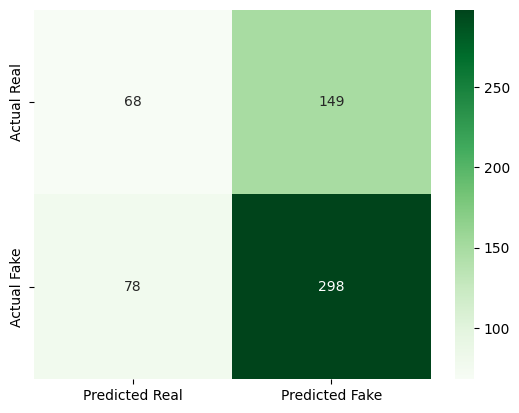

In [102]:
conf_matrix_log_reg = confusion_matrix(y_test, log_reg_y_pred)
sns.heatmap(conf_matrix_log_reg, annot=True, cmap='Greens', fmt='.0f',
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

plt.savefig('../figures/log_reg_confusion_matrix.jpeg')



In [103]:
print(classification_report(y_test, log_reg_y_pred))

              precision    recall  f1-score   support

           0       0.47      0.31      0.37       217
           1       0.67      0.79      0.72       376

    accuracy                           0.62       593
   macro avg       0.57      0.55      0.55       593
weighted avg       0.59      0.62      0.60       593



In [ ]:
embed_dim = 64

# reshape from 2D to 3D
X_train_title_text_svd_LSTM = X_train_title_text_svd.reshape(X_train_title_text_svd.shape[0], 1, X_train_title_text_svd.shape[1])
X_test_title_text_svd_LSTM = X_test_title_text_svd.reshape(X_test_title_text_svd.shape[0], 1, X_test_title_text_svd.shape[1])

model = Sequential()
# model.add(Embedding(vocab_size, embed_dim, input_length=X_train_title_text_svd.shape[1]))
# model.add(SpatialDropout1D(0.25))
model.add(LSTM(units=128, dropout=0.5, recurrent_dropout=0.5, kernel_initializer='uniform', input_shape=(X_train_title_text_svd_LSTM.shape[1], X_train_title_text_svd_LSTM.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=30, activation='relu', kernel_initializer='uniform'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/Users/pkchoy/Portfo/fake-news-classifier/fake-news/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 256)            │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │         7,710 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 578,109 (2.21 MB)

 Trainable params: 578,109 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
print(np.isnan(X_train_title_text_svd).sum())
print(f"Vocabulary size: {len(title_text_tokeniser.word_index)}")

0
Vocabulary size: 35979


In [106]:
print(y_train.shape)
history = model.fit(X_train_title_text_svd_LSTM, y_train, epochs=50, batch_size=64, validation_split=0.2)

(1381,)
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4825 - loss: 0.7098 - val_accuracy: 0.6498 - val_loss: 0.6691
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5394 - loss: 0.6889 - val_accuracy: 0.6751 - val_loss: 0.6513
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5714 - loss: 0.6790 - val_accuracy: 0.6895 - val_loss: 0.6371
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5697 - loss: 0.6734 - val_accuracy: 0.6643 - val_loss: 0.6291
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5665 - loss: 0.6805 - val_accuracy: 0.6823 - val_loss: 0.6291
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5963 - loss: 0.6651 - val_accuracy: 0.6751 - val_loss: 0.6302
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5975 - loss: 0.6677 - val_accuracy: 0.6715 - val_loss: 0.6355
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5708 - loss: 0.6844 - val_accuracy: 0.6534 - 

In [107]:
nn_y_pred = model.predict(X_test_title_text_svd_LSTM)

threshold = round(754/(1220+754), 2)

print(threshold)
nn_y_pred = np.where(nn_y_pred > threshold, 1, 0)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
0.38


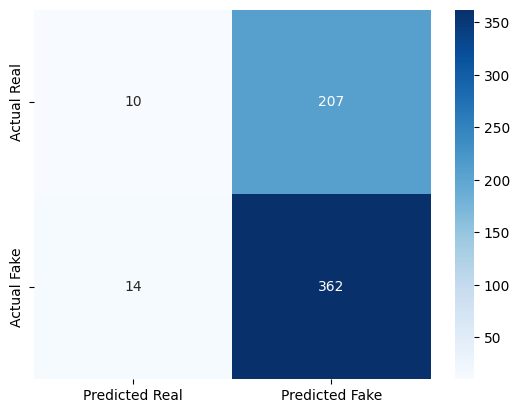

In [108]:
conf_matrix_nn = confusion_matrix(y_test, nn_y_pred)
sns.heatmap(conf_matrix_nn, annot=True, cmap='Blues', fmt='.0f',
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

plt.savefig('../figures/nn_confusion_matrix.jpeg')

In [109]:
print(classification_report(y_test, nn_y_pred))

              precision    recall  f1-score   support

           0       0.42      0.05      0.08       217
           1       0.64      0.96      0.77       376

    accuracy                           0.63       593
   macro avg       0.53      0.50      0.42       593
weighted avg       0.56      0.63      0.52       593

